In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV


In this homework we consider the Lotka-Volterra ODE systems

$$\frac{d}{dt} {p}_{prey} = \alpha p_{prey} - \beta p_{prey} p_{predator}$$

$$\frac{d}{dt} {p}_{predator} = - \gamma p_{predator} + \delta p_{prey} p_{predator}$$

Here $\alpha, \beta, \gamma, \delta > 0$ are the parameters of the model.

In [ ]:
def lotka_volterra(p, t, alpha, beta, delta, gamma):

    # Define the RHS of LV model
    # input parameters: alpha, beta, gamma, delta
    # p: state of the system, array of size 2
    # t: time, scalar
    # output: d/dt p

    prey, predator = p
    dprey_dt = alpha * prey - beta * prey * predator
    dpredator_dt = delta * prey * predator - gamma * predator
    return [dprey_dt, dpredator_dt]


The following code simulates the LV model for parameters $(\alpha, \beta, \gamma, \delta) = (1, 0.1, 0.075, 1.5]$ over the interval $[0, 20]$.

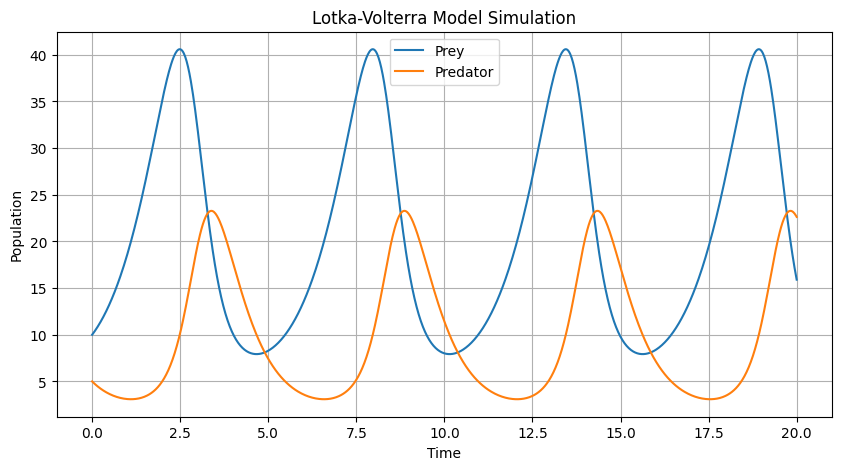

In [ ]:

def simulate_lotka_volterra(
    alpha=1.0,
    beta=0.1,
    delta=0.075,
    gamma=1.5,
    p0=(10, 5),
    T=20,
    num_points=1000
):
    """
    Simulates the Lotka-Volterra system.

    Parameters:
    alpha, beta, delta, gamma : float
        Parameters of the Lotka-Volterra model.
    p0 : tuple
        Initial conditions (prey, predator).
    T : float
        Total simulation time.
    num_points : int
        Number of points in the time grid.

    Returns:
    t : ndarray
        Time points.
    sol : ndarray
        Solution array (prey, predator).
    """
    t = np.linspace(0, T, num_points)
    sol = odeint(lotka_volterra, p0, t, args=(alpha, beta, delta, gamma))
    return t, sol

# Set parameters
alpha = 1.0   # Prey birth rate
beta = 0.1    # Predation rate
delta = 0.075 # Predator reproduction rate
gamma = 1.5   # Predator death rate

# Initial population
p0 = (10, 5)

# Simulation settings
T = 20            # Total time
num_points = 1000 # Number of time points

# Run simulation
t, sol = simulate_lotka_volterra(alpha, beta, delta, gamma, p0, T, num_points)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(t, sol[:, 0], label='Prey')
plt.plot(t, sol[:, 1], label='Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Lotka-Volterra Model Simulation')
plt.legend()
plt.grid(True)
plt.show()

We assume that we will not see the entire trajectory of the system, but rather observe the predator and prey populations at a limited number of observation points in time. In the following code the 'dt_obs' parameter denotes the time interval between two observations.

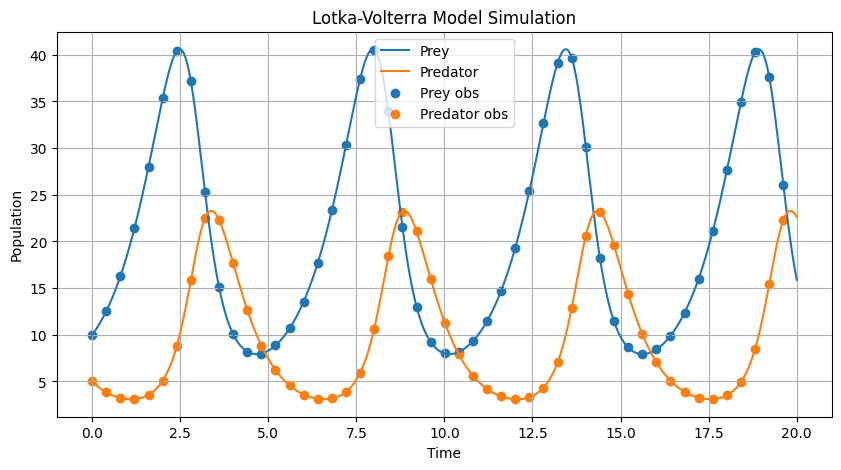

In [ ]:
delta_t_obs = 0.4

skip = int(np.rint(delta_t_obs*num_points/T))

y = sol[0::skip]
ty = t[0::skip]

# Plot results
plt.figure(figsize=(10,5))

plt.plot(t, sol[:, 0], label='Prey')
plt.plot(t, sol[:, 1], label='Predator')

plt.scatter(ty, y[:, 0], label='Prey obs')
plt.scatter(ty, y[:, 1], label='Predator obs')

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Lotka-Volterra Model Simulation')
plt.legend()
plt.grid(True)
plt.show()

Your goal in this homework is to learn the right hand side of the LV system from the limited data $(t_n, y_n)_{n=0}^N$ where
$$ t_n = \frac{T}{\delta t_{obs}}i \quad \text{and} \quad  
y_n = \big(p_{prey}(t_n), p_{predator}(t_n) \big).$$
You will do this in three steps:

Step 1) Given the above data, use kernel ridge regression to approximate the prey and predator trajectories as functions of time, i.e.,
$$ \hat{p}_{prey}(t) \approx p_{prey}(t),
\qquad \text{and} \qquad
\hat{p}_{predator}(t) \approx p_{predator}(t)$$
for $t \in [0, T]$.  

Best KRR params (prey):     {'alpha': 0.1, 'gamma': np.float64(1.6681005372000592)}
Best KRR params (predator): {'alpha': 0.01, 'gamma': np.float64(0.027825594022071243)}
'The alpha and gamma above are sci-kit's internal hyperparameters!'
'These have nothing to do with the ODE constants.'
'alpha is sci-kit's regulaization weight/ridge penalty.'
'gamma is sci-kit's width of the exponential RBF kernel, i.e. an inverse length-scale.'
'gamma appeasr in the K(t, t') = exp(-gamma(t-t')^2) kernel definition!'


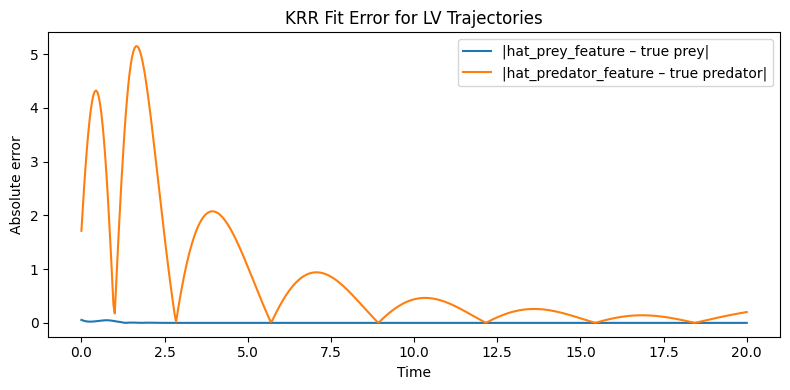

→ saved step1_krr_fit_error.pdf


<Figure size 640x480 with 0 Axes>

In [ ]:
# True Lotka–Volterra parameters
alpha, beta, gamma, delta = 1.0, 0.1, 0.075, 1.5

def lotka_volterra(t, y):
    p1, p2 = y
    return [
        alpha * p1 - beta * p1 * p2,
        -gamma * p2 + delta * p1 * p2
    ]

# Observation times & simulate “true” data
t_obs = np.arange(50) * 0.4          # t_n = 0.4·n, n=0…49
sol_obs = solve_ivp(lotka_volterra, [0, 20], [1.0, 5.0], t_eval=t_obs)
p1_obs, p2_obs = sol_obs.y

# Setup & cross‐validate KRR models
param_grid = {
    'alpha': [1e-2, 1e-1, 1.0, 10.0],
    'gamma': np.logspace(-2, 2, 10)
}
base_krr = KernelRidge(kernel='rbf')

grid_prey     = GridSearchCV(base_krr, param_grid, cv=5)
grid_predator = GridSearchCV(base_krr, param_grid, cv=5)

grid_prey.fit(t_obs.reshape(-1, 1), p1_obs)
grid_predator.fit(t_obs.reshape(-1, 1), p2_obs)

print("Best KRR params (prey):    ", grid_prey.best_params_)
print("Best KRR params (predator):", grid_predator.best_params_)
print("'The alpha and gamma above are sci-kit's internal hyperparameters!'")
print("'These have nothing to do with the ODE constants.'")
print("'alpha is sci-kit's regulaization weight/ridge penalty.'")
print("'gamma is sci-kit's width of the exponential RBF kernel, i.e. an inverse length-scale.'")
print("'gamma appeasr in the K(t, t') = exp(-gamma(t-t')^2) kernel definition!'")


# Dense grid & feature extraction
t_dense = np.linspace(0, 20, 500)
sol_dense = solve_ivp(lotka_volterra, [0, 20], [1.0, 5.0], t_eval=t_dense)
p1_true, p2_true = sol_dense.y

hat_prey_feature     = grid_prey.predict(t_dense.reshape(-1, 1))
hat_predator_feature = grid_predator.predict(t_dense.reshape(-1, 1))

# Plot absolute errors
plt.figure(figsize=(8, 4))
plt.plot(t_dense, np.abs(hat_prey_feature     - p1_true), label='|hat_prey_feature – true prey|')
plt.plot(t_dense, np.abs(hat_predator_feature - p2_true), label='|hat_predator_feature – true predator|')
plt.xlabel('Time')
plt.ylabel('Absolute error')
plt.title('KRR Fit Error for LV Trajectories')
plt.legend()
plt.tight_layout()
plt.show()
save_pdf('step1_krr_fit_error.pdf')


Step 2) Estimate the time derivatives $\frac{d}{dt}{p}_{prey}$ and $\frac{d}{dt}{p}_{predator}$ by computing $\frac{d}{dt}\hat{p}_{prey}$ and $\frac{d}{dt} \hat{p}_{predator}$ on the time grid $(t_n)_{n=1}^N$

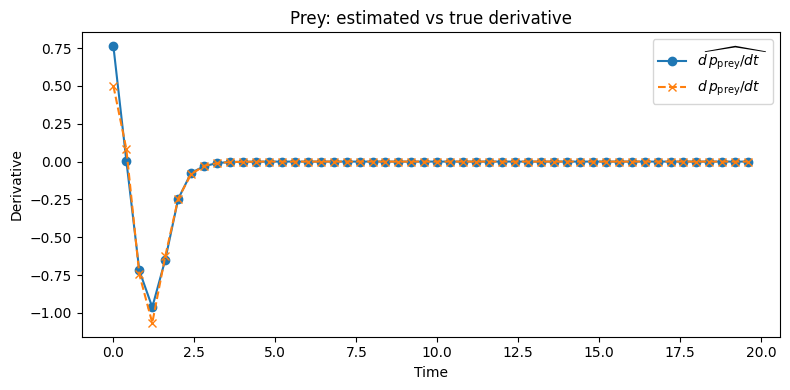

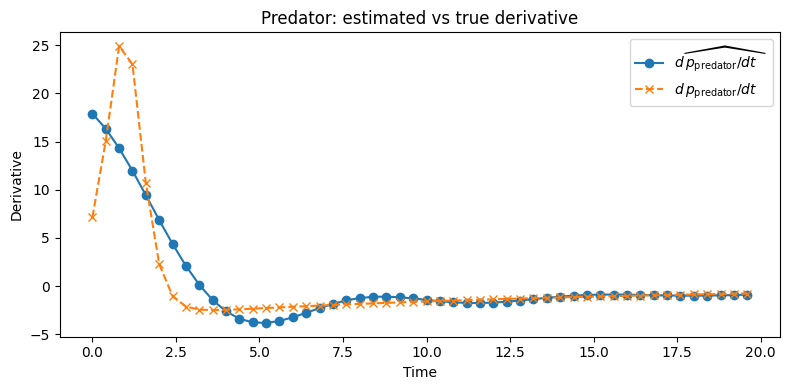

→ saved step2_pred_derivative_error.pdf


<Figure size 640x480 with 0 Axes>

In [ ]:
# — Assumes the following are already in your namespace from Step 1: —
#   grid_prey, grid_predator  : fitted KernelRidge CV objects
#   t_obs                     : array of shape (N,) with t_n = 0.4·n
#   p1_obs, p2_obs            : the true LV values at t_obs
#   alpha, beta, gamma, delta : the true LV parameters (for comparison)

def krr_time_derivative(model, t):
    """
    Compute f'(t) for a 1D RBF‐KRR model via the representer theorem:
      f'(t) = Σ_j α_j ∂_t K(t, t_j)
            = Σ_j α_j [ -2γ (t - t_j) e^{-γ (t - t_j)^2} ].
    """
    # training inputs (shape (N_train,1)) and dual coefs (shape (N_train,))
    X_train = model.X_fit_.ravel()
    coefs   = model.dual_coef_.ravel()
    gamma_k = model.get_params()['gamma']

    # build difference matrix: shape (N_eval, N_train)
    D = t.reshape(-1,1) - X_train.reshape(1,-1)
    K = np.exp(-gamma_k * D**2)
    dK = -2 * gamma_k * D * K

    # f'(t) at each evaluation point
    return dK.dot(coefs)   # shape (N_eval,)

#GridSearrchCV

krr_prey     = grid_prey.best_estimator_     # this is the fitted KernelRidge
krr_predator = grid_predator.best_estimator_

# Compute the estimated derivatives at the original t_obs
dt_hat_prey     = krr_time_derivative(krr_prey,     t_obs)
dt_hat_predator = krr_time_derivative(krr_predator, t_obs)

# (Optional) compute the true ODE right‐hand sides for comparison
dp_prey_true     =  alpha * p1_obs - beta  * p1_obs * p2_obs
dp_pred_true     = -gamma * p2_obs + delta * p1_obs * p2_obs

# Plot prey derivative: estimate vs true
plt.figure(figsize=(8,4))
plt.plot(t_obs, dt_hat_prey,     'o-', label=r'$\widehat{d\,p_{\mathrm{prey}}/dt}$')
plt.plot(t_obs, dp_prey_true,     'x--', label=r'$d\,p_{\mathrm{prey}}/dt$')
plt.xlabel('Time'); plt.ylabel('Derivative')
plt.title('Prey: estimated vs true derivative')
plt.legend(); plt.tight_layout(); plt.show()

# Plot predator derivative: estimate vs true
plt.figure(figsize=(8,4))
plt.plot(t_obs, dt_hat_predator, 'o-', label=r'$\widehat{d\,p_{\mathrm{predator}}/dt}$')
plt.plot(t_obs, dp_pred_true,     'x--', label=r'$d\,p_{\mathrm{predator}}/dt$')
plt.xlabel('Time'); plt.ylabel('Derivative')
plt.title('Predator: estimated vs true derivative')
plt.legend(); plt.tight_layout(); plt.show()
save_pdf('step2_pred_derivative_error.pdf')


Step 3) Observing that the LV system is of the generic form

$$
\frac{d}{dt} p_{prey} = f_{prey}( p_{prey}, p_{predator} ) \\
\frac{d}{dt} p_{predator} = f_{predator}( p_{prey}, p_{predator} )
$$

Use your estimated values for $\hat{p}_{prey}, \hat{p}_{predator}, \frac{d}{dt}\hat{p}_{prey}, \frac{d}{dt} \hat{p}_{predator}$ at $(t_i)_{i=1}^N$ to formulate a second kernel ridge regression problem for the functions $\hat f_{prey} \approx f_{prey}$ and $\hat f_{predator} \approx f_{predator}$.

Training support: p1 ∈ [-0.00,1.11], p2 ∈ [6.71,36.47]
Best params: {'alpha': 0.001, 'gamma': 0.1}
Best params: {'alpha': 0.001, 'gamma': 2.0}


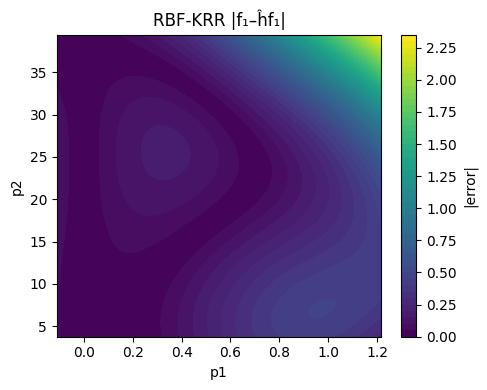

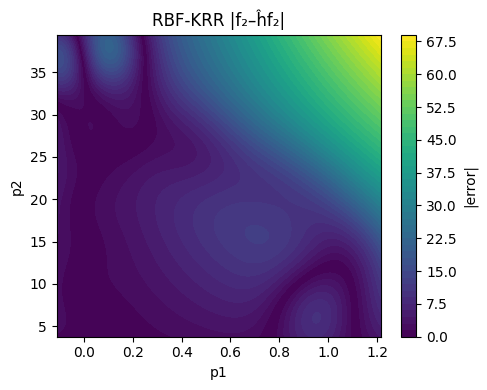

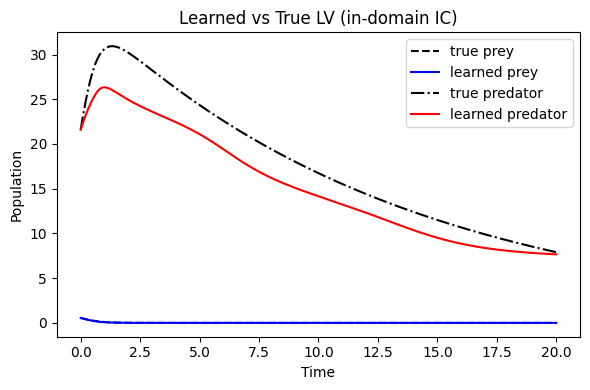

→ saved step3_refined_contour_cross_validation.pdf


<Figure size 640x480 with 0 Axes>

In [ ]:
# --- Complete, fixed Step 3 ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.integrate import solve_ivp

# --- Helpers ---

def unwrap(model):
    """If GridSearchCV, return best_estimator_, else return model."""
    return model.best_estimator_ if hasattr(model, "best_estimator_") else model

def krr_time_derivative(kr_model, t):
    """
    Analytic ∂/∂t of RBF–KRR:
      f(t) = Σ a_j K(t, t_j),  K=exp(-γ(t-t_j)^2)
      ⇒ f'(t) = Σ a_j [-2γ (t-t_j) K(t,t_j)].
    """
    kr = unwrap(kr_model)
    Xj = kr.X_fit_.ravel()
    aj = kr.dual_coef_.ravel()
    γ  = kr.gamma
    D  = t.reshape(-1,1) - Xj.reshape(1,-1)
    K  = np.exp(-γ * D**2)
    dK = -2 * γ * D * K
    return dK.dot(aj)

# --- 1) Build training set on dense t2 grid ---

t2       = np.linspace(0, 20, 100)
kr_prey     = unwrap(grid_prey)
kr_predator = unwrap(grid_predator)

p1_hat2  = kr_prey.predict(t2.reshape(-1,1))
p2_hat2  = kr_predator.predict(t2.reshape(-1,1))
dp1_hat2 = krr_time_derivative(kr_prey,     t2)
dp2_hat2 = krr_time_derivative(kr_predator, t2)

# Stack into (N×2) → (N,) regression problem
X_train  = np.column_stack([p1_hat2, p2_hat2])
y1_train = dp1_hat2
y2_train = dp2_hat2

print(f"Training support: p1 ∈ [{p1_hat2.min():.2f},{p1_hat2.max():.2f}], "
      f"p2 ∈ [{p2_hat2.min():.2f},{p2_hat2.max():.2f}]")

# --- 2) Scale X & y, then cross-validate two new KRR surrogates ---

# Scale inputs
scaler_X = StandardScaler().fit(X_train)
X_s = scaler_X.transform(X_train)

# Parameter grid: no tiny γ, very small α
param_grid = {
    "alpha": [1e-6, 1e-5, 1e-4, 1e-3],
    "gamma": [0.05, 0.1, 0.2, 0.5, 1.0, 2.0]
}

def fit_scaled_krr(X_scaled, y):
    # center+rescale y
    ym, ys = y.mean(), y.std()
    y_scaled = (y - ym) / ys

    gs = GridSearchCV(KernelRidge(kernel="rbf"), param_grid, cv=5)
    gs.fit(X_scaled, y_scaled)
    print("Best params:", gs.best_params_)

    kr = gs.best_estimator_
    # return a predict function that undoes y–scaling
    return lambda Xq: (kr.predict(scaler_X.transform(Xq)) * ys + ym)

# Fit f1, f2
f1 = fit_scaled_krr(X_s, y1_train)
f2 = fit_scaled_krr(X_s, y2_train)

# --- 3) Contour error over ±10% around training hull ---

p1_min,p1_max = p1_hat2.min(), p1_hat2.max()
p2_min,p2_max = p2_hat2.min(), p2_hat2.max()
m1 = 0.1*(p1_max-p1_min)
m2 = 0.1*(p2_max-p2_min)

p1g = np.linspace(p1_min-m1, p1_max+m1, 200)
p2g = np.linspace(p2_min-m2, p2_max+m2, 200)
P1, P2 = np.meshgrid(p1g, p2g)
XX = np.column_stack([P1.ravel(), P2.ravel()])

# True LV RHS on mesh
f1_true = (alpha*P1 - beta*P1*P2).ravel()
f2_true = (-gamma*P2 + delta*P1*P2).ravel()

for true_vals, pred_func, title in [
    (f1_true, f1, "RBF-KRR |f₁–ĥf₁|"),
    (f2_true, f2, "RBF-KRR |f₂–ĥf₂|")
]:
    pred = pred_func(XX)
    err  = np.abs(pred - true_vals).reshape(P1.shape)
    plt.figure(figsize=(5,4))
    plt.contourf(P1, P2, err, levels=50)
    plt.colorbar(label="|error|")
    plt.title(title)
    plt.xlabel("p1"); plt.ylabel("p2")
    plt.tight_layout()

# --- 4) Simulate learned vs true from an interior IC ---

ic = [0.5*(p1_min + p1_max), 0.5*(p2_min + p2_max)]
t_test = np.linspace(0, 20, 200)
sol_true  = solve_ivp(lotka_volterra, [0,20], ic, t_eval=t_test)

def rhs_learned(t,y):
    return [f1([[y[0],y[1]]])[0],
            f2([[y[0],y[1]]])[0]]

sol_learn = solve_ivp(rhs_learned, [0,20], ic, t_eval=t_test)

plt.figure(figsize=(6,4))
plt.plot(sol_true.t, sol_true.y[0], 'k--', label="true prey")
plt.plot(sol_learn.t, sol_learn.y[0],'b-',  label="learned prey")
plt.plot(sol_true.t, sol_true.y[1], 'k-.', label="true predator")
plt.plot(sol_learn.t, sol_learn.y[1],'r-',  label="learned predator")
plt.legend(); plt.title("Learned vs True LV (in-domain IC)")
plt.xlabel("Time"); plt.ylabel("Population")
plt.tight_layout()
plt.show()

save_pdf('step3_refined_contour_cross_validation.pdf')


  training support: p1 ∈ [-0.00,1.11], p2 ∈ [6.71,36.47]
  best params: {'alpha': 0.01, 'gamma': np.float64(10.0)}
  best params: {'alpha': 0.0001, 'gamma': np.float64(0.001)}


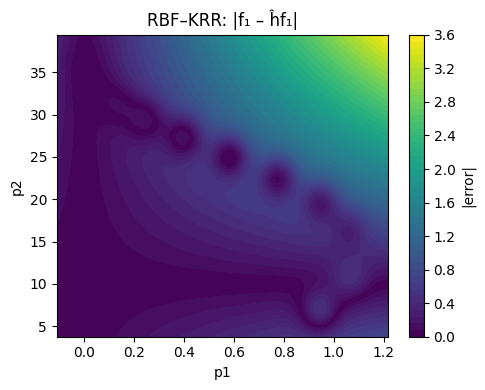

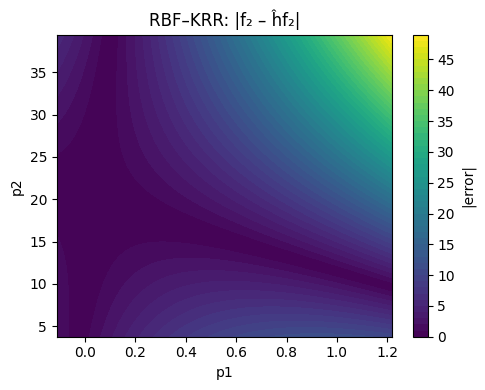

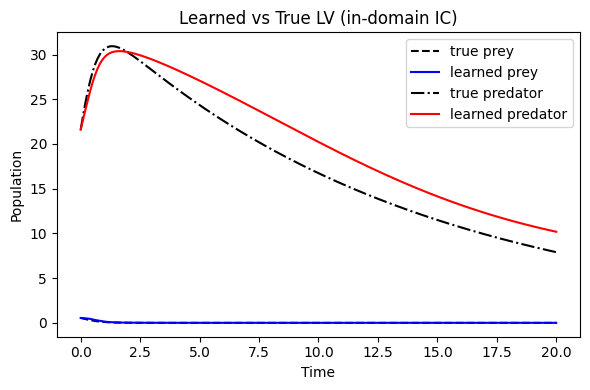

→ saved step3_final.pdf


<Figure size 640x480 with 0 Axes>

In [ ]:
# Step 3 (Fixed): proper scaling + sensible RBF grid so f₁,f₂ actually learn

import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.integrate import solve_ivp

# 1) unwrap your GridSearchCV → KernelRidge fits
kr_prey     = grid_prey.best_estimator_
kr_predator = grid_predator.best_estimator_

# 2) helper to compute ∂/∂t of an RBF–KRR fit
def krr_time_derivative(kr, t):
    Xj    = kr.X_fit_.ravel()
    aj    = kr.dual_coef_.ravel()
    γ     = kr.gamma
    D     = t.reshape(-1,1) - Xj.reshape(1,-1)
    K     = np.exp(-γ * D**2)
    dK    = -2 * γ * D * K
    return dK.dot(aj)

# 3) build your (p1,p2) → dp/dt training data on a fine t2 grid
t2        = np.linspace(0, 20, 100)
p1_hat2   = kr_prey.predict(t2.reshape(-1,1))
p2_hat2   = kr_predator.predict(t2.reshape(-1,1))
dp1_hat2  = krr_time_derivative(kr_prey,     t2)
dp2_hat2  = krr_time_derivative(kr_predator, t2)

X_train   = np.column_stack([p1_hat2, p2_hat2])   # shape (100,2)
y1_train  = dp1_hat2                              # shape (100,)
y2_train  = dp2_hat2

print(f"  training support: p1 ∈ [{p1_hat2.min():.2f},{p1_hat2.max():.2f}], "
      f"p2 ∈ [{p2_hat2.min():.2f},{p2_hat2.max():.2f}]")

# 4) scale inputs to zero mean/unit variance
scaler = StandardScaler().fit(X_train)
Xs     = scaler.transform(X_train)

# 5) choose a sensible RBF grid (no crazy tiny γ or huge α)
param_grid = {
    "alpha": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    "gamma": np.logspace(-3, 1, 8)
}

def fit_krr_rbf(Xs, y):
    gs = GridSearchCV(KernelRidge(kernel="rbf"), param_grid, cv=5)
    gs.fit(Xs, y)
    print("  best params:", gs.best_params_)
    return gs.best_estimator_

# 6) fit surrogates on the scaled data
model1 = fit_krr_rbf(Xs, y1_train)
model2 = fit_krr_rbf(Xs, y2_train)

# wrap predictions back to original space
f1 = lambda Q: model1.predict(scaler.transform(Q))
f2 = lambda Q: model2.predict(scaler.transform(Q))

# 7) contour error only over ±10% around training hull
p1_min, p1_max = p1_hat2.min(), p1_hat2.max()
p2_min, p2_max = p2_hat2.min(), p2_hat2.max()
m1 = 0.1*(p1_max - p1_min)
m2 = 0.1*(p2_max - p2_min)

p1g = np.linspace(p1_min - m1, p1_max + m1, 200)
p2g = np.linspace(p2_min - m2, p2_max + m2, 200)
P1, P2 = np.meshgrid(p1g, p2g)
PP      = np.column_stack([P1.ravel(), P2.ravel()])

# true LV RHS on this mesh
f1_true = (alpha*P1 - beta*P1*P2).ravel()
f2_true = (-gamma*P2 + delta*P1*P2).ravel()

for true_vals, pred_fn, title in [
    (f1_true, f1, "RBF–KRR: |f₁ – ĥf₁|"),
    (f2_true, f2, "RBF–KRR: |f₂ – ĥf₂|")
]:
    err = np.abs(pred_fn(PP) - true_vals).reshape(P1.shape)
    plt.figure(figsize=(5,4))
    plt.contourf(P1, P2, err, levels=50)
    plt.colorbar(label="|error|")
    plt.title(title)
    plt.xlabel("p1")
    plt.ylabel("p2")
    plt.tight_layout()

# 8) simulate learned vs true from an interior IC
ic       = [(p1_min+p1_max)/2, (p2_min+p2_max)/2]
t_test   = np.linspace(0, 20, 200)
sol_true = solve_ivp(lotka_volterra, [0,20], ic, t_eval=t_test)

def rhs_learned(t, y):
    return [f1([[y[0],y[1]]])[0],
            f2([[y[0],y[1]]])[0]]

sol_learn = solve_ivp(rhs_learned, [0,20], ic, t_eval=t_test)

plt.figure(figsize=(6,4))
plt.plot(sol_true.t,  sol_true.y[0], 'k--', label="true prey")
plt.plot(sol_learn.t, sol_learn.y[0], 'b-',  label="learned prey")
plt.plot(sol_true.t,  sol_true.y[1], 'k-.', label="true predator")
plt.plot(sol_learn.t, sol_learn.y[1], 'r-',  label="learned predator")
plt.legend(loc="upper right")
plt.xlabel("Time"); plt.ylabel("Population")
plt.title("Learned vs True LV (in-domain IC)")
plt.tight_layout()
plt.show()

save_pdf('step3_final.pdf')


Support: p1∈[-0.00,1.11], p2∈[6.71,36.47]
Best Poly² params: {'alpha': 0.001, 'coef0': 1.0, 'degree': 2, 'gamma': 1.0}
Best Poly² params: {'alpha': 0.001, 'coef0': 1.0, 'degree': 2, 'gamma': 1.0}
IC at predator trough: [np.float64(0.9444004727679942), np.float64(6.713360036073711)]
→ saved step3_Poly_squared_KRR_vs.True.pdf


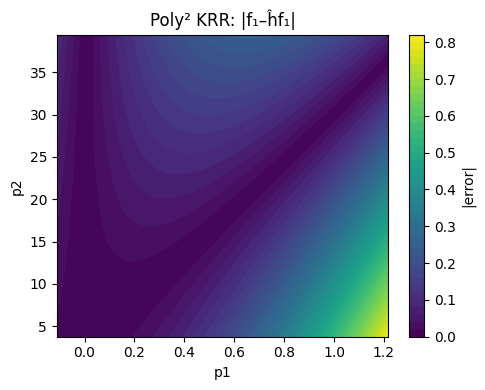

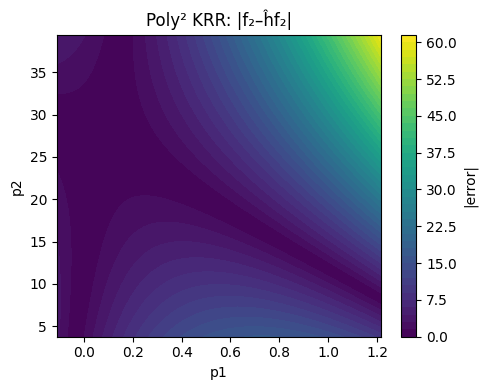

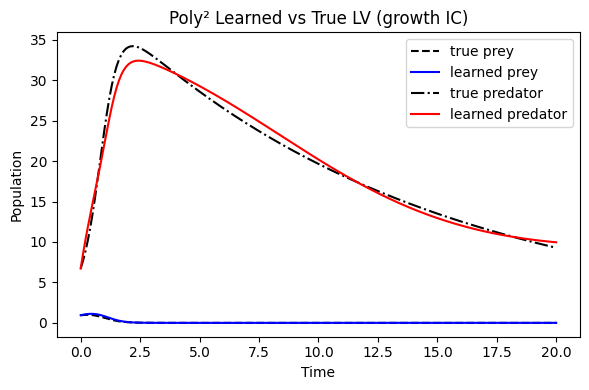

In [ ]:
# Step 3 (Poly² + “growth” IC): quadratic KRR + new IC at predator trough

import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.integrate import solve_ivp

# — helper to unwrap GridSearchCV →
def unwrap(model):
    return model.best_estimator_ if hasattr(model, "best_estimator_") else model

# — analytic derivative of RBF–KRR (for building training data) —
def krr_time_derivative(kr, t):
    Xj = kr.X_fit_.ravel()
    aj = kr.dual_coef_.ravel()
    γ  = kr.gamma
    D  = t.reshape(-1,1) - Xj.reshape(1,-1)
    K  = np.exp(-γ * D**2)
    return (-2*γ * D * K).dot(aj)

# 1) Build (p1,p2)→dp/dt training set on fine t2 grid
t2         = np.linspace(0,20,100)
kr_prey    = unwrap(grid_prey)
kr_predator= unwrap(grid_predator)

p1_hat2    = kr_prey.predict(t2.reshape(-1,1))
p2_hat2    = kr_predator.predict(t2.reshape(-1,1))
dp1_hat2   = krr_time_derivative(kr_prey,    t2)
dp2_hat2   = krr_time_derivative(kr_predator,t2)

X_train    = np.column_stack([p1_hat2, p2_hat2])
y1_train   = dp1_hat2
y2_train   = dp2_hat2

print(f"Support: p1∈[{p1_hat2.min():.2f},{p1_hat2.max():.2f}], "
      f"p2∈[{p2_hat2.min():.2f},{p2_hat2.max():.2f}]")

# 2) Scale inputs
scaler = StandardScaler().fit(X_train)
Xs     = scaler.transform(X_train)

# 3) Poly² hyper‐grid & CV fit
poly_grid = {
    "alpha":  [1e-6,1e-5,1e-4,1e-3],
    "degree": [2],
    "gamma":  [1.0],
    "coef0":  [0.0,1.0]
}

def fit_poly(Xs, y):
    gs = GridSearchCV(KernelRidge(kernel="poly"), poly_grid, cv=5)
    gs.fit(Xs, y)
    print("Best Poly² params:", gs.best_params_)
    return gs.best_estimator_

model1_poly = fit_poly(Xs, y1_train)  # f₁ surrogate
model2_poly = fit_poly(Xs, y2_train)  # f₂ surrogate

# prediction wrappers
f1_poly = lambda Q: model1_poly.predict(scaler.transform(Q))
f2_poly = lambda Q: model2_poly.predict(scaler.transform(Q))

# 4) Contour error on training hull ±10%
p1_min,p1_max = p1_hat2.min(), p1_hat2.max()
p2_min,p2_max = p2_hat2.min(), p2_hat2.max()
m1 = 0.1*(p1_max-p1_min); m2 = 0.1*(p2_max-p2_min)

p1g = np.linspace(p1_min-m1, p1_max+m1, 200)
p2g = np.linspace(p2_min-m2, p2_max+m2, 200)
P1,P2 = np.meshgrid(p1g, p2g)
PP    = np.column_stack([P1.ravel(),P2.ravel()])

# true LV RHS on mesh
f1_true = (alpha*P1 - beta*P1*P2).ravel()
f2_true = (-gamma*P2 + delta*P1*P2).ravel()

for true_vals, pred_fn, title in [
    (f1_true, f1_poly, "Poly² KRR: |f₁–ĥf₁|"),
    (f2_true, f2_poly, "Poly² KRR: |f₂–ĥf₂|")
]:
    err = np.abs(pred_fn(PP) - true_vals).reshape(P1.shape)
    plt.figure(figsize=(5,4))
    plt.contourf(P1, P2, err, levels=50)
    plt.colorbar(label="|error|")
    plt.title(title); plt.xlabel("p1"); plt.ylabel("p2")
    plt.tight_layout()

# 5) New IC at predator trough (minimal p2_hat2)
i_trough   = np.argmin(p2_hat2)
ic_trough  = [p1_hat2[i_trough], p2_hat2[i_trough]]
print("IC at predator trough:", ic_trough)

t_test   = np.linspace(0,20,200)
sol_true = solve_ivp(lotka_volterra, [0,20], ic_trough, t_eval=t_test)

def rhs_poly(t,y):
    return [f1_poly([[y[0],y[1]]])[0],
            f2_poly([[y[0],y[1]]])[0]]

sol_poly = solve_ivp(rhs_poly, [0,20], ic_trough, t_eval=t_test)

plt.figure(figsize=(6,4))
plt.plot(sol_true.t, sol_true.y[0], 'k--', label="true prey")
plt.plot(sol_poly.t, sol_poly.y[0],'b-',  label="learned prey")
plt.plot(sol_true.t, sol_true.y[1], 'k-.', label="true predator")
plt.plot(sol_poly.t, sol_poly.y[1],'r-',  label="learned predator")
plt.legend(loc="upper right")
plt.xlabel("Time"); plt.ylabel("Population")
plt.title("Poly² Learned vs True LV (growth IC)")
plt.tight_layout()
save_pdf('step3_Poly_squared_KRR_vs.True.pdf')
plt.show()
